In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
import scipy.stats as stats
from scipy.stats import genpareto

sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('spy.csv',parse_dates=['Date'])

#the price is multiplied by 10

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1985-01-02,167.20,167.20,165.19,165.37,37677778.0
1,1985-01-03,165.37,166.11,164.38,164.57,49377778.0
2,1985-01-04,164.55,164.55,163.36,163.68,43044444.0
3,1985-01-07,163.68,164.71,163.68,164.24,47883333.0
4,1985-01-08,164.24,164.59,163.91,163.99,51172222.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume
10149,2025-04-14,5441.96,5459.46,5358.02,5405.97,3.287278e+09
10150,2025-04-15,5411.99,5450.41,5386.44,5396.63,2.856819e+09
10151,2025-04-16,5335.75,5367.24,5220.79,5275.70,3.352866e+09
10152,2025-04-17,5305.45,5328.31,5255.58,5282.70,3.153700e+09
10153,2025-04-21,5232.94,5232.94,5101.63,5158.20,2.964605e+09


### Look at Log returns


In [6]:
df["Returns"] = np.log(df['Close'] / df['Close'].shift(1)).dropna()
print(df.head())
print(df.tail())

        Date    Open    High     Low   Close      Volume   Returns
0 1985-01-02  167.20  167.20  165.19  165.37  37677778.0       NaN
1 1985-01-03  165.37  166.11  164.38  164.57  49377778.0 -0.004849
2 1985-01-04  164.55  164.55  163.36  163.68  43044444.0 -0.005423
3 1985-01-07  163.68  164.71  163.68  164.24  47883333.0  0.003415
4 1985-01-08  164.24  164.59  163.91  163.99  51172222.0 -0.001523
            Date     Open     High      Low    Close        Volume   Returns
10149 2025-04-14  5441.96  5459.46  5358.02  5405.97  3.287278e+09  0.007913
10150 2025-04-15  5411.99  5450.41  5386.44  5396.63  2.856819e+09 -0.001729
10151 2025-04-16  5335.75  5367.24  5220.79  5275.70  3.352866e+09 -0.022663
10152 2025-04-17  5305.45  5328.31  5255.58  5282.70  3.153700e+09  0.001326
10153 2025-04-21  5232.94  5232.94  5101.63  5158.20  2.964605e+09 -0.023850


# Plot of LOG RETURNS

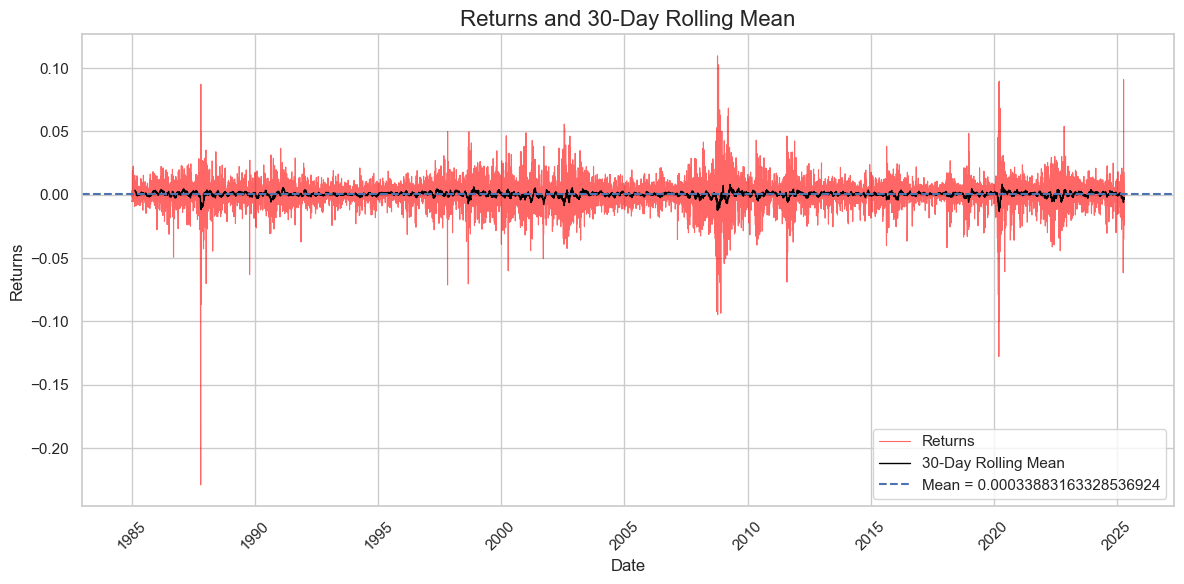

In [8]:

rolling_mean = df['Returns'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Returns'], label='Returns', color='red', alpha=0.6, linewidth = 0.8)
sns.lineplot(x=df['Date'], y=rolling_mean, label='30-Day Rolling Mean', color='black', linewidth=1)
plt.axhline(y=df['Returns'].mean(), color='b', linestyle='--', label = "Mean = 0.00033883163328536924")


plt.title('Returns and 30-Day Rolling Mean', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.xticks(rotation=45) 
plt.legend()
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

The overall mean is very small but positive. Eventually will make money.

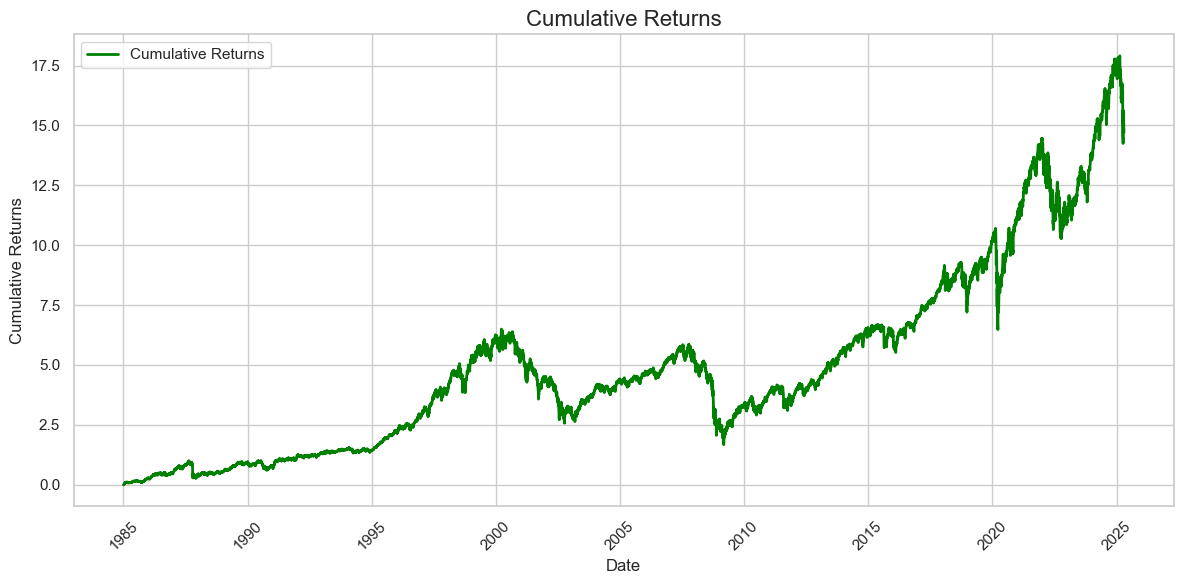

In [10]:

df['Cumulative_Returns'] = (1 + df['Returns']).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Cumulative_Returns'], label='Cumulative Returns', color='green', linewidth=2)
plt.title('Cumulative Returns', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

## ACF and PACF of the data

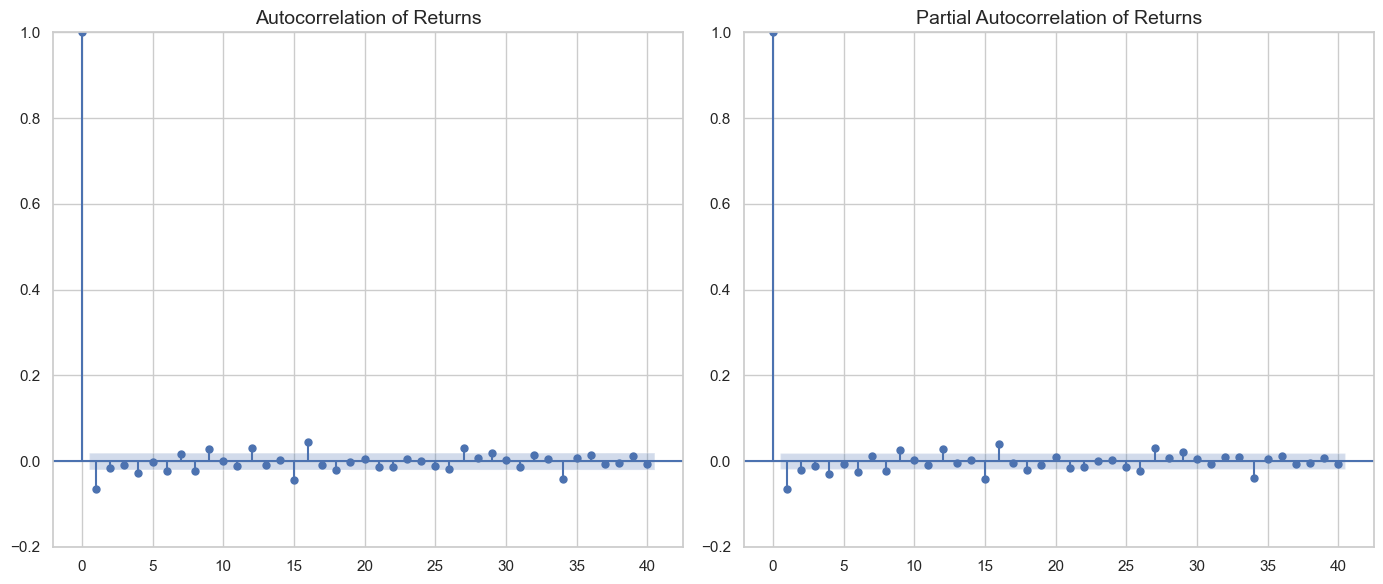

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF
plot_acf(df['Returns'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation of Returns', fontsize=14)
axes[0].set_ylim(-0.2, 1)  # Adjust y-axis limits

# PACF
plot_pacf(df['Returns'].dropna(), lags=40, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation of Returns', fontsize=14)
axes[1].set_ylim(-0.2, 1)  # Adjust y-axis limits

plt.tight_layout()
plt.show()

## ACF and PACF of squared returns

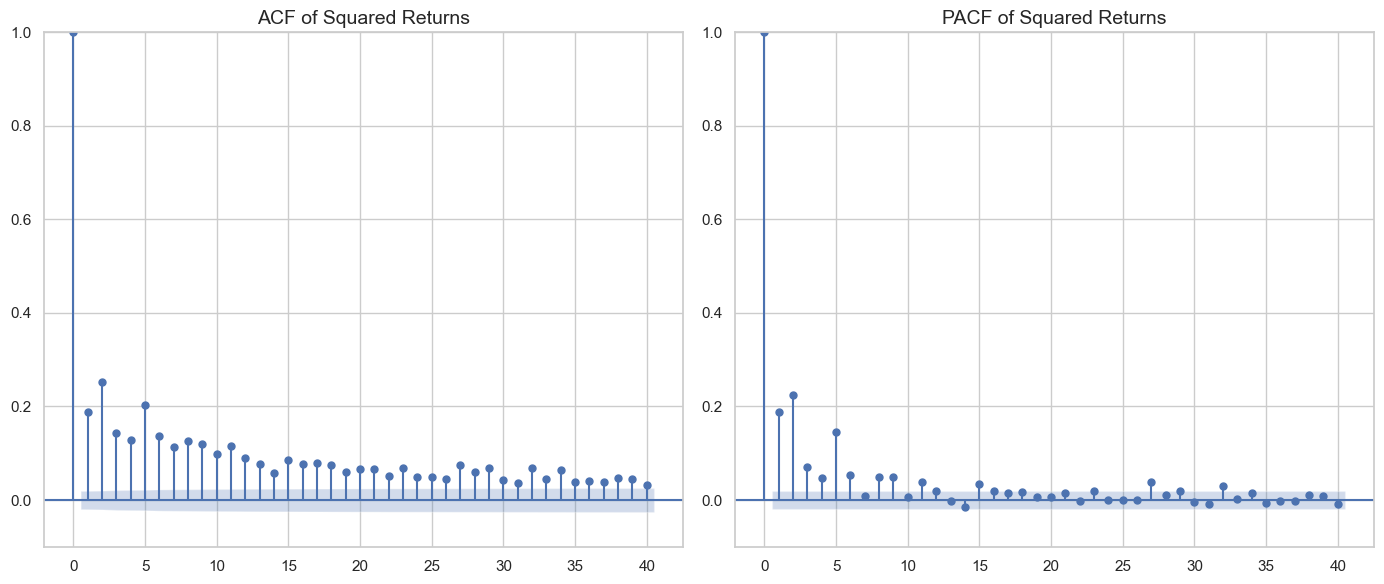

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Squared returns
squared_returns = df['Returns'].dropna() ** 2

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF of squared returns
plot_acf(squared_returns, lags=40, ax=axes[0])
axes[0].set_title('ACF of Squared Returns', fontsize=14)
axes[0].set_ylim(-0.1, 1)

# PACF of squared returns
plot_pacf(squared_returns, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Squared Returns', fontsize=14)
axes[1].set_ylim(-0.1, 1)

plt.tight_layout()
plt.show()

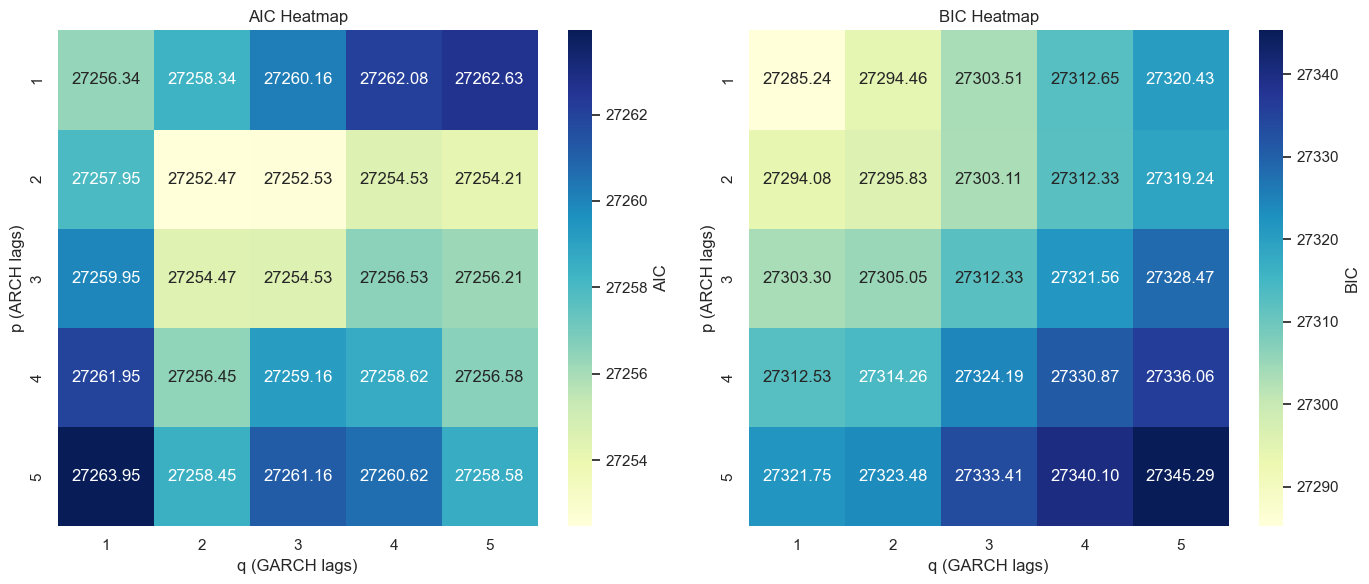

In [15]:
 #Step 1: Assuming 'df' already contains the returns data in the 'Returns' column
returns = df['Returns'].dropna()  # Make sure to drop missing values

# Step 2: Rescale the returns by multiplying by 100 to avoid scaling issues
returns = returns * 100  # Rescale the returns

# Step 3: Set up range for p (lags for ARCH term) and q (lags for GARCH term)
p_values = range(1, 6)  # Try 1 to 5 for p
q_values = range(1, 6)  # Try 1 to 5 for q

# Step 4: Create empty lists to store AIC and BIC values
aic_values = []
bic_values = []

# Step 5: Fit GARCH models for all combinations of p and q
for p in p_values:
    for q in q_values:
        try:
            model = arch_model(returns, vol='Garch', p=p, q=q)
            model_fit = model.fit(disp="off")
            
            # Store the AIC and BIC values
            aic_values.append(model_fit.aic)
            bic_values.append(model_fit.bic)
        except Exception as e:
            print(f"Error fitting model with p={p} and q={q}: {e}")
            aic_values.append(np.nan)
            bic_values.append(np.nan)

# Step 6: Convert results into a DataFrame for easier plotting
aic_matrix = np.array(aic_values).reshape(len(p_values), len(q_values))
bic_matrix = np.array(bic_values).reshape(len(p_values), len(q_values))

# Step 7: Plot heatmap for AIC and BIC values
plt.figure(figsize=(14, 6))

# Plot AIC Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(aic_matrix, xticklabels=q_values, yticklabels=p_values, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'AIC'})
plt.title("AIC Heatmap")
plt.xlabel('q (GARCH lags)')
plt.ylabel('p (ARCH lags)')

# Plot BIC Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(bic_matrix, xticklabels=q_values, yticklabels=p_values, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'BIC'})
plt.title("BIC Heatmap")
plt.xlabel('q (GARCH lags)')
plt.ylabel('p (ARCH lags)')

plt.tight_layout()
plt.show()

In [16]:
df.head()

,Date,Open,High,Low,Close,Volume,Returns,Cumulative_Returns
0,1985-01-02,167.20,167.20,165.19,165.37,37677778.0,NaN,NaN
1,1985-01-03,165.37,166.11,164.38,164.57,49377778.0,-0.004849,-0.004849
2,1985-01-04,164.55,164.55,163.36,163.68,43044444.0,-0.005423,-0.010246
3,1985-01-07,163.68,164.71,163.68,164.24,47883333.0,0.003415,-0.006865
4,1985-01-08,164.24,164.59,163.91,163.99,51172222.0,-0.001523,-0.008378


# Fit GARCH(1,1) With normal residuals


Returns multiplied with 100 to scale and fit the model better


In [18]:

df['Returns'] = df['Returns']*100
model = arch_model(df['Returns'].dropna(), vol='Garch', p=1, q=1)
results = model.fit()

print(df.head())

print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2025046216837101.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1083351000.315878
Iteration:      3,   Func. Count:     24,   Neg. LLF: 18709.806686629156
Iteration:      4,   Func. Count:     31,   Neg. LLF: 13831.302212839368
Iteration:      5,   Func. Count:     37,   Neg. LLF: 13642.40318483453
Iteration:      6,   Func. Count:     43,   Neg. LLF: 14082.910039891834
Iteration:      7,   Func. Count:     49,   Neg. LLF: 13625.10628753282
Iteration:      8,   Func. Count:     55,   Neg. LLF: 13624.169089157538
Iteration:      9,   Func. Count:     60,   Neg. LLF: 13624.168401050432
Iteration:     10,   Func. Count:     65,   Neg. LLF: 13624.168399225622
Iteration:     11,   Func. Count:     69,   Neg. LLF: 13624.168399225204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13624.168399225622
            Iterations: 11
            Function evaluations: 69
            Gradient evalua

In [19]:
df.head()

,Date,Open,High,Low,Close,Volume,Returns,Cumulative_Returns
0,1985-01-02,167.20,167.20,165.19,165.37,37677778.0,NaN,NaN
1,1985-01-03,165.37,166.11,164.38,164.57,49377778.0,-0.484938,-0.004849
2,1985-01-04,164.55,164.55,163.36,163.68,43044444.0,-0.542271,-0.010246
3,1985-01-07,163.68,164.71,163.68,164.24,47883333.0,0.341547,-0.006865
4,1985-01-08,164.24,164.59,163.91,163.99,51172222.0,-0.152332,-0.008378


### Test for normality of residuals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2025046216837101.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1083351000.315878
Iteration:      3,   Func. Count:     24,   Neg. LLF: 18709.806686629156
Iteration:      4,   Func. Count:     31,   Neg. LLF: 13831.302212839368
Iteration:      5,   Func. Count:     37,   Neg. LLF: 13642.40318483453
Iteration:      6,   Func. Count:     43,   Neg. LLF: 14082.910039891834
Iteration:      7,   Func. Count:     49,   Neg. LLF: 13625.10628753282
Iteration:      8,   Func. Count:     55,   Neg. LLF: 13624.169089157538
Iteration:      9,   Func. Count:     60,   Neg. LLF: 13624.168401050432
Iteration:     10,   Func. Count:     65,   Neg. LLF: 13624.168399225622
Iteration:     11,   Func. Count:     69,   Neg. LLF: 13624.168399225204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13624.168399225622
            Iterations: 11
            Function evaluations: 69
            Gradient evalua

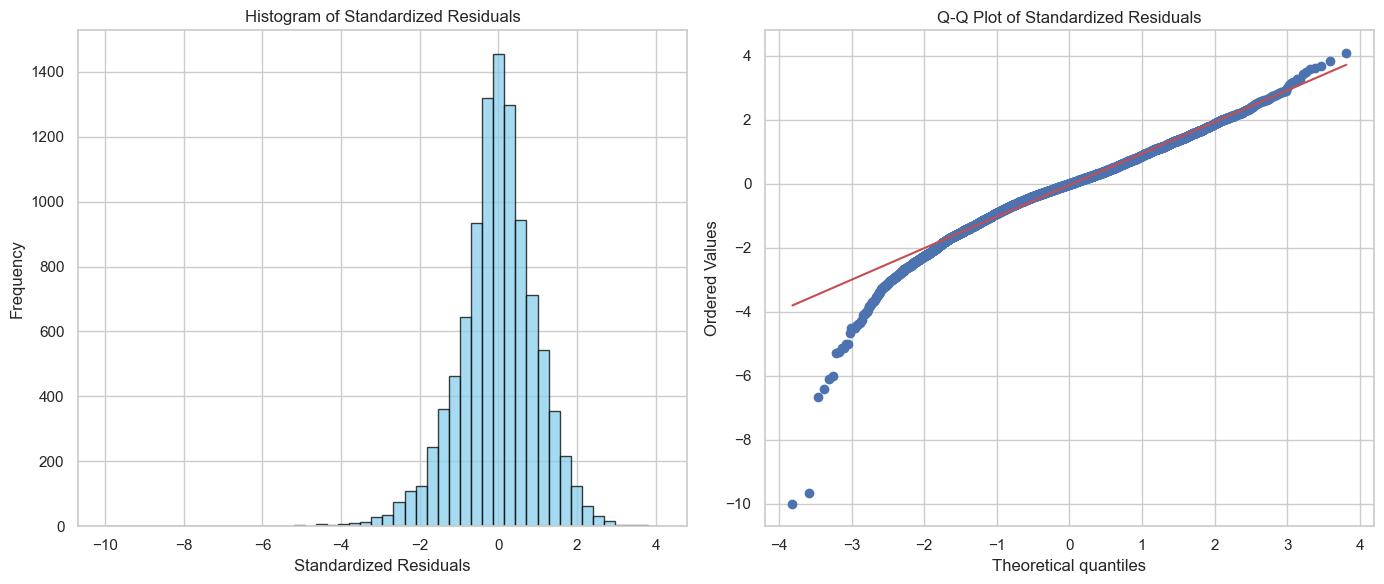

In [21]:

# Fit the GARCH(1,1) model
model = arch_model(df['Returns'].dropna(), vol='Garch', p=1, q=1)
results = model.fit()

# Get the residuals and the conditional standard deviation
residuals = results.resid
conditional_volatility = results.conditional_volatility

# Standardize the residuals
standardized_residuals = residuals / conditional_volatility

# Add standardized residuals to the dataframe
df['Standardized Residuals'] = standardized_residuals

# Create the plot with two subplots: histogram and Q-Q plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram
axs[0].hist(df['Standardized Residuals'].dropna(), bins=50, alpha=0.75, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Standardized Residuals')
axs[0].set_xlabel('Standardized Residuals')
axs[0].set_ylabel('Frequency')

# Plot Q-Q plot
stats.probplot(df['Standardized Residuals'].dropna(), dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot of Standardized Residuals')

# Show the plots
plt.tight_layout()
plt.show()



In [22]:
print(df.head())

        Date    Open    High     Low   Close      Volume   Returns  \
0 1985-01-02  167.20  167.20  165.19  165.37  37677778.0       NaN   
1 1985-01-03  165.37  166.11  164.38  164.57  49377778.0 -0.484938   
2 1985-01-04  164.55  164.55  163.36  163.68  43044444.0 -0.542271   
3 1985-01-07  163.68  164.71  163.68  164.24  47883333.0  0.341547   
4 1985-01-08  164.24  164.59  163.91  163.99  51172222.0 -0.152332   

   Cumulative_Returns  Standardized Residuals  
0                 NaN                     NaN  
1           -0.004849               -0.695120  
2           -0.010246               -0.782767  
3           -0.006865                0.360822  
4           -0.008378               -0.294559  


# Fit GARCH but with t-residuals

In [24]:
# t-distributed errors
model_t = arch_model(df['Returns'].dropna(), vol='Garch', p=1, q=1, dist='t')
results_t = model_t.fit()


print(results_t.summary())


Iteration:      1,   Func. Count:      7,   Neg. LLF: 342831.2445683332
Iteration:      2,   Func. Count:     19,   Neg. LLF: 136606.14969920323
Iteration:      3,   Func. Count:     28,   Neg. LLF: 82274.45839585346
Iteration:      4,   Func. Count:     36,   Neg. LLF: 13348.84168916006
Iteration:      5,   Func. Count:     43,   Neg. LLF: 22192.44889511491
Iteration:      6,   Func. Count:     50,   Neg. LLF: 13346.436906078216
Iteration:      7,   Func. Count:     57,   Neg. LLF: 13292.151357537517
Iteration:      8,   Func. Count:     64,   Neg. LLF: 15828.66778033252
Iteration:      9,   Func. Count:     72,   Neg. LLF: 13289.323657902147
Iteration:     10,   Func. Count:     78,   Neg. LLF: 13289.924547418348
Iteration:     11,   Func. Count:     86,   Neg. LLF: 13289.441973889354
Iteration:     12,   Func. Count:     93,   Neg. LLF: 13289.300459088512
Iteration:     13,   Func. Count:     99,   Neg. LLF: 13289.30023801722
Iteration:     14,   Func. Count:    104,   Neg. LLF: 132

In [25]:
print(df.head())

        Date    Open    High     Low   Close      Volume   Returns  \
0 1985-01-02  167.20  167.20  165.19  165.37  37677778.0       NaN   
1 1985-01-03  165.37  166.11  164.38  164.57  49377778.0 -0.484938   
2 1985-01-04  164.55  164.55  163.36  163.68  43044444.0 -0.542271   
3 1985-01-07  163.68  164.71  163.68  164.24  47883333.0  0.341547   
4 1985-01-08  164.24  164.59  163.91  163.99  51172222.0 -0.152332   

   Cumulative_Returns  Standardized Residuals  
0                 NaN                     NaN  
1           -0.004849               -0.695120  
2           -0.010246               -0.782767  
3           -0.006865                0.360822  
4           -0.008378               -0.294559  


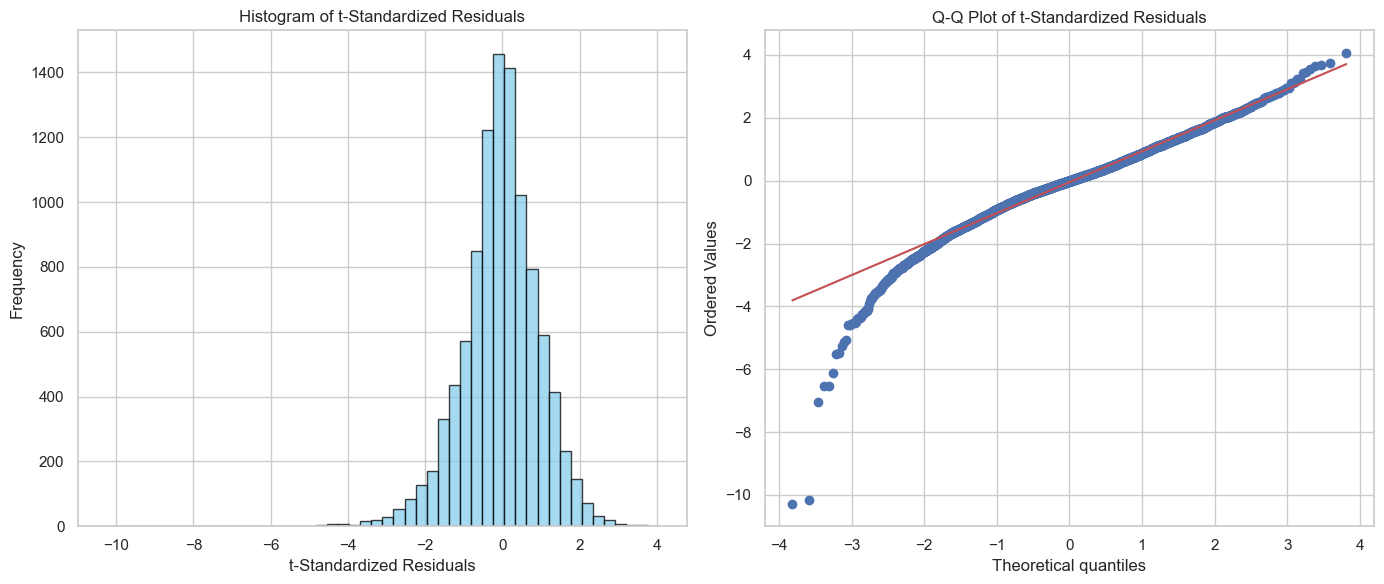

In [26]:

# Get the residuals and the conditional standard deviation
residuals_t = results_t.resid
conditional_volatility_t = results_t.conditional_volatility

# Standardize the residuals
standardized_residuals_t = residuals_t / conditional_volatility_t
# Add standardized residuals to the dataframe


df['t Standardized Residuals'] = standardized_residuals_t  # removed trailing space

# Create the plot with two subplots: histogram and Q-Q plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram
axs[0].hist(df['t Standardized Residuals'].dropna(), bins=50, alpha=0.75, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of t-Standardized Residuals')
axs[0].set_xlabel('t-Standardized Residuals')
axs[0].set_ylabel('Frequency')

# Plot Q-Q plot
stats.probplot(df['t Standardized Residuals'].dropna(), dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot of t-Standardized Residuals')

# Show the plots
plt.tight_layout()
plt.show()

### Residuals with time

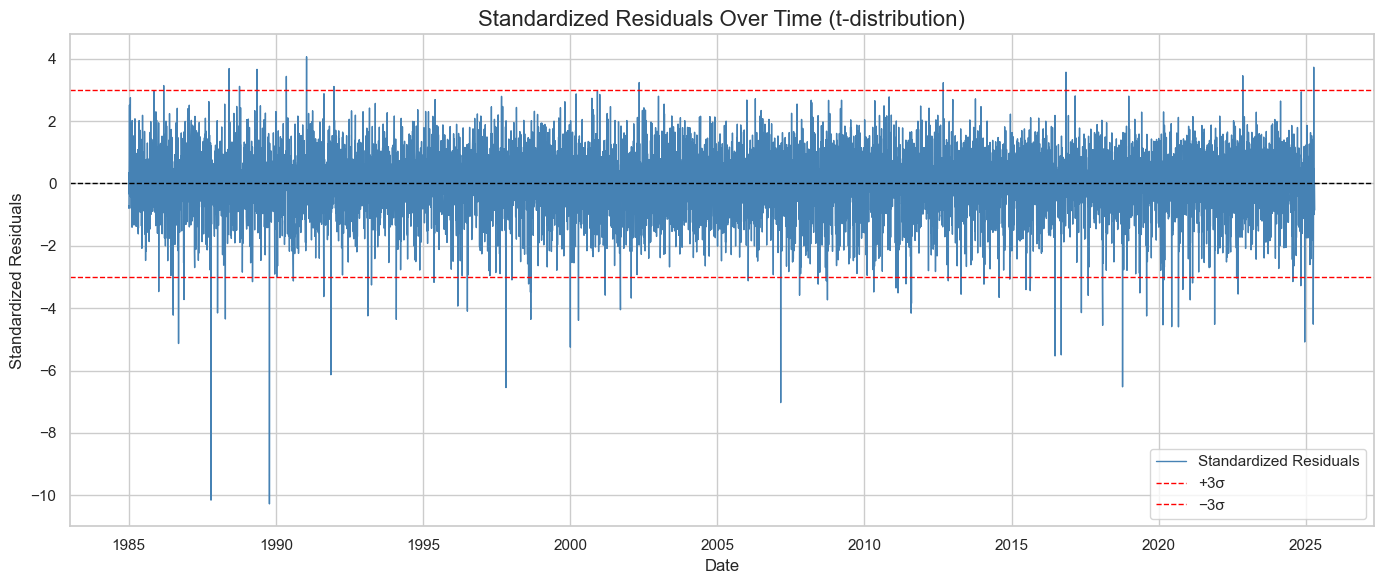

In [28]:
# Create the plot
plt.figure(figsize=(14, 6))
sns.lineplot(x=df['Date'], y = standardized_residuals_t, label='Standardized Residuals',  color='steelblue', linewidth=1)

# Optional: Highlight ±3 standard deviation lines
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(3, color='red', linestyle='--', linewidth=1, label='+3σ')
plt.axhline(-3, color='red', linestyle='--', linewidth=1, label='−3σ')

# Labels and legend
plt.title('Standardized Residuals Over Time (t-distribution)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.tight_layout()

plt.show()

In [29]:
#save residuals to csv
"""
aligned_dates = df.loc[standardized_residuals_t.index, 'Date']

# Or if 'Date' is your index:
# aligned_dates = df.index[std_resid.index]

# Create DataFrame
resid_df = pd.DataFrame({
    'Date': aligned_dates,
    'Std_Residuals': standardized_residuals_t
})

# Save to CSV
resid_df.to_csv('std_residuals.csv', index=False)
"""

"\naligned_dates = df.loc[standardized_residuals_t.index, 'Date']\n\n# Or if 'Date' is your index:\n# aligned_dates = df.index[std_resid.index]\n\n# Create DataFrame\nresid_df = pd.DataFrame({\n    'Date': aligned_dates,\n    'Std_Residuals': standardized_residuals_t\n})\n\n# Save to CSV\nresid_df.to_csv('std_residuals.csv', index=False)\n"

In [30]:
df.head()

,Date,Open,High,Low,Close,Volume,Returns,Cumulative_Returns,Standardized Residuals,t Standardized Residuals
0,1985-01-02,167.20,167.20,165.19,165.37,37677778.0,NaN,NaN,NaN,NaN
1,1985-01-03,165.37,166.11,164.38,164.57,49377778.0,-0.484938,-0.004849,-0.695120,-0.711817
2,1985-01-04,164.55,164.55,163.36,163.68,43044444.0,-0.542271,-0.010246,-0.782767,-0.797703
3,1985-01-07,163.68,164.71,163.68,164.24,47883333.0,0.341547,-0.006865,0.360822,0.345247
4,1985-01-08,164.24,164.59,163.91,163.99,51172222.0,-0.152332,-0.008378,-0.294559,-0.308667


In [31]:
# Forecast volatility for 2 days ahead
np.random.seed(2312)
forecast = results_t.forecast(horizon=2)

# Extract predicted variances
var_tomorrow = forecast.variance.iloc[-1, 0]
var_day_after = forecast.variance.iloc[-1, 1]

# Convert to standard deviation (undo scaling)
vol_tomorrow = np.sqrt(var_tomorrow) / 100
vol_day_after = np.sqrt(var_day_after) / 100

# Extract mu and nu from the t-distribution model
mu = results_t.params['mu'] / 100  # undo the scaling
nu = results_t.params['nu']

# Simulate t-distributed shocks
shock_tomorrow = np.random.standard_t(nu)
shock_day_after = np.random.standard_t(nu)

# Compute log returns
log_ret_tomorrow = mu + vol_tomorrow * shock_tomorrow
log_ret_day_after = mu + vol_day_after * shock_day_after

# Get the current price
current_price = df["Close"].iloc[-1]

# Forecast prices using exponentiated log returns
price_tomorrow = current_price * np.exp(log_ret_tomorrow)/10
price_day_after = price_tomorrow * np.exp(log_ret_day_after)

# Print forecasted results
print(f"Closing Price on 21 April: {current_price/10} ")
print(f"Forecasted price 22 April: ${price_tomorrow:.2f}")
print(f"Actual Closing Price on 22 April: $527")
print(f"Forecasted price 23 April: ${price_day_after:.2f}")

Closing Price on 21 April: 515.8199999999999 
Forecasted price 22 April: $530.68
Actual Closing Price on 22 April: $527
Forecasted price 23 April: $546.48


# EVT analysis

In [33]:
data = df[["Date", "t Standardized Residuals"]].dropna()
data["Residuals"] = -data["t Standardized Residuals"]
data = data.drop(columns=["t Standardized Residuals"])

In [34]:
data.head()

,Date,Residuals
1,1985-01-03,0.711817
2,1985-01-04,0.797703
3,1985-01-07,-0.345247
4,1985-01-08,0.308667
5,1985-01-09,-0.904167


# PEAK OVER THRESHOLD 

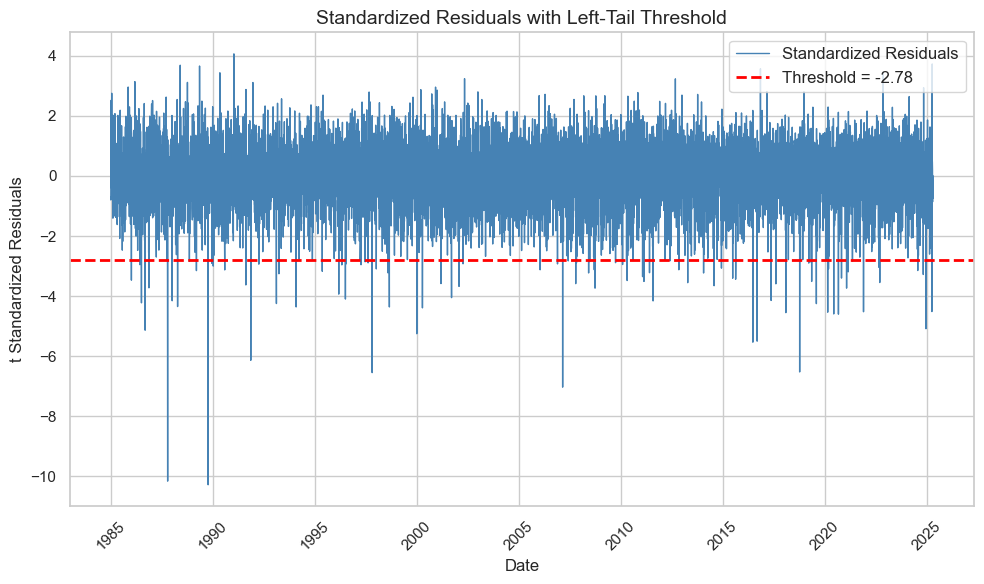

In [80]:
plt.figure(figsize=(10, 6))

threshold = standardized_residuals_t.quantile(0.01)
# Plot original standardized residuals (not flipped)
plt.plot(data["Date"], standardized_residuals_t, color='steelblue', lw=1, label='Standardized Residuals')

# Add threshold line at the 5th percentile
plt.axhline(y=threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')

plt.title("Standardized Residuals with Left-Tail Threshold", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("t Standardized Residuals", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
threshold

-2.7830713730263295

In [84]:
exceedances = threshold - standardized_residuals_t[standardized_residuals_t < threshold] 

In [86]:
shape, loc, scale = genpareto.fit(exceedances, floc=0)

print(f"Threshold (u): {threshold:.4f}")
print(f"Shape (ξ): {shape:.4f}")
print(f"Scale (β): {scale:.4f}")

Threshold (u): -2.7831
Shape (ξ): 0.2561
Scale (β): 0.7333


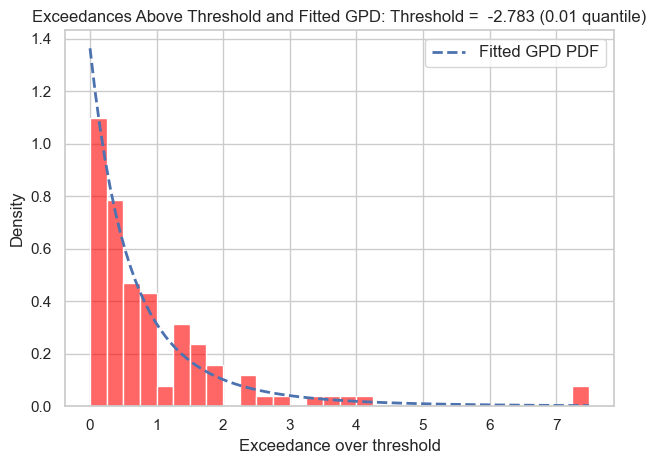

In [90]:
x = np.linspace(0, exceedances.max(), 100)
pdf = genpareto.pdf(x, c=shape, loc=0, scale=scale)

g = sns.histplot(exceedances, bins=30, kde=False, stat="density", color='red', alpha = 0.6)

# Plot the fitted GPD PDF as a red line, using Seaborn's plt accessor to add it
g.plot(x, pdf, 'b--', lw=2, label='Fitted GPD PDF')

# Set the title and labels with more emphasis
g.set(title="Exceedances Above Threshold and Fitted GPD: Threshold =  -2.783 (0.01 quantile)",
      xlabel="Exceedance over threshold", ylabel="Density")

# Add the legend and adjust its position
g.legend(fontsize=12, loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

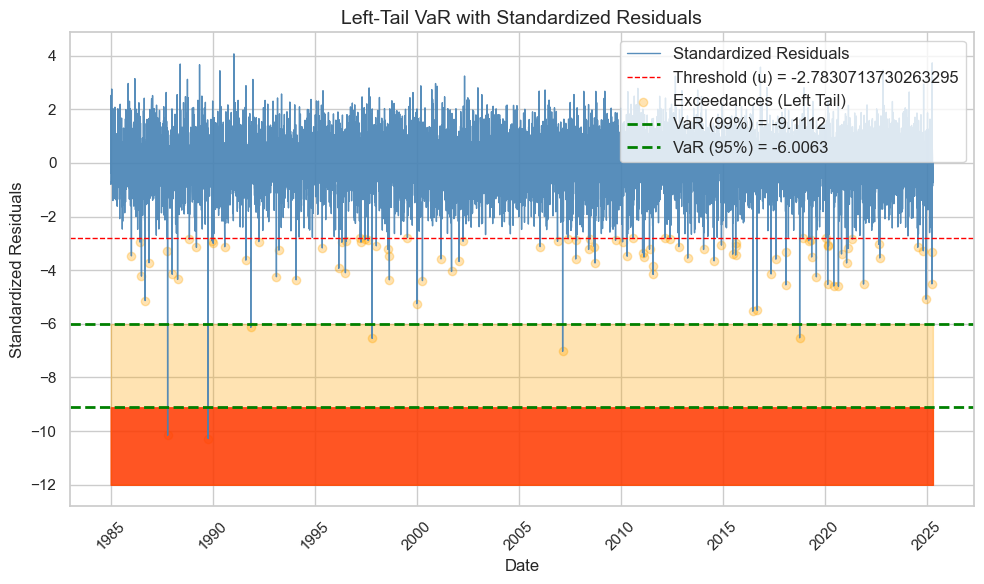

In [92]:
residuals = standardized_residuals_t  # Replace with your residuals data (already cleaned)

threshold_u = threshold  # Threshold (u) for left tail
xi = shape            # Shape parameter (ξ)
beta = scale          # Scale parameter (β)



q_u = 0.05  # Exceedance proportion (left tail)
VaR_99 = threshold_u - (beta / xi) * (((1 - q_u) / (1 - 0.99)) ** xi - 1)

VaR_95 = threshold_u - (beta / xi) * (((1 - q_u) / (1 - 0.95)) ** xi - 1)
VaR_90 = threshold_u - (beta / xi) * (((1 - q_u) / (1 - 0.90)) ** xi - 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the residuals (standardized residuals over time)
plt.plot(data['Date'], residuals, color='steelblue', label='Standardized Residuals', lw=1,alpha = 0.9)

# Add threshold line (red dashed line)
plt.axhline(y=threshold_u, color='red', linestyle='--', lw=1, label=f'Threshold (u) = {threshold_u}')

# Highlight exceedances below the threshold (use a condition)
exceedances = residuals[residuals < threshold_u]
plt.scatter(data['Date'][residuals < threshold_u], exceedances, color='orange', label='Exceedances (Left Tail)', alpha=0.3)

# Add VaR line (dashed green line for 99% VaR)
plt.axhline(y=VaR_99, color='green', linestyle='--', lw=2, label=f'VaR (99%) = {VaR_99:.4f}')
plt.fill_between(data['Date'], y1=VaR_99, y2=-12, color='red', alpha=0.8)
plt.axhline(y=VaR_95, color='green', linestyle='--', lw=2, label=f'VaR (95%) = {VaR_95:.4f}')
plt.fill_between(data['Date'], y1=VaR_95, y2=-12, color='orange', alpha=0.3)

# Title and axis labels
plt.title('Left-Tail VaR with Standardized Residuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Standardized Residuals', fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Apply tight layout to make sure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()

# EVT 

In [44]:
quantile_25 = data['Residuals'].quantile(0.1)
quantile_75 = data['Residuals'].quantile(0.05)
print(f"0.25 Quantile: {quantile_25}")
print(f"0.75 Quantile: {quantile_75}")


0.25 Quantile: -1.1443890608343514
0.75 Quantile: -1.4880463958054049
